# Stock Return Prediction

As part of our student project, we are participating in the Qube Research & Technologies (QRT) financial prediction challenge, which focuses on forecasting the sign of residual stock returns—returns adjusted to remove overall market impact—using recent historical data.

The dataset includes over 600,000 observations, split into 418,595 training samples and 198,429 test samples. Each sample contains 20 days of historical residual returns and relative volumes, along with categorical features such as STOCK, SECTOR, INDUSTRY, and SUB_INDUSTRY. The objective is to predict whether the return on a given day is positive or negative, using only this historical and contextual information.

The evaluation metric is accuracy, based on correctly classifying the return sign. 

Through this project, our team aims to explore advanced modeling approaches, including gradient boosting, deep learning, and random forest, to better extract predictive signals from noisy financial data. This challenge provides a hands-on opportunity to apply data science techniques in a high-dimensional, real-world market context.

## Used libraries

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
import time


## Loading data

The train and test inputs are composed of 46 features.

The target of this challenge is `RET` and corresponds to the fact that the **return is in the top 50% of highest stock returns**.

Since the median is very close to 0, this information should not change much with the idea to predict the sign of the return.

In [2]:
# The files are assumed to be in the specified paths
x_train = pd.read_csv('~/Desktop/QRT/x_train.csv', index_col='ID')
y_train = pd.read_csv('~/Desktop/QRT/y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1)
test = pd.read_csv('~/Desktop/QRT/x_test.csv', index_col='ID')
train.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN,True
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,False
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806,False


## Data Cleaning

Before training any predictive models, we ensure the dataset is clean, consistent, and properly formatted. In this step, we focused on identifying and handling missing values, verifying data types, and checking for anomalies or outliers in the input features. 

Since the dataset includes 40 numerical time-series features (returns and volumes) and several categorical identifiers (such as STOCK, SECTOR, and INDUSTRY), we also ensured that all features were encoded appropriately for modeling. Missing values in the time-series data were handled, while categorical variables were processed to maintain consistency across training and test sets. 

In [3]:
# Check data types and missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418595 entries, 0 to 418594
Data columns (total 47 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            418595 non-null  int64  
 1   STOCK           418595 non-null  int64  
 2   INDUSTRY        418595 non-null  int64  
 3   INDUSTRY_GROUP  418595 non-null  int64  
 4   SECTOR          418595 non-null  int64  
 5   SUB_INDUSTRY    418595 non-null  int64  
 6   RET_1           416236 non-null  float64
 7   VOLUME_1        353570 non-null  float64
 8   RET_2           416130 non-null  float64
 9   VOLUME_2        352209 non-null  float64
 10  RET_3           416088 non-null  float64
 11  VOLUME_3        350776 non-null  float64
 12  RET_4           416051 non-null  float64
 13  VOLUME_4        347598 non-null  float64
 14  RET_5           416011 non-null  float64
 15  VOLUME_5        343902 non-null  float64
 16  RET_6           415998 non-null  float64
 17  VOLUME_6       

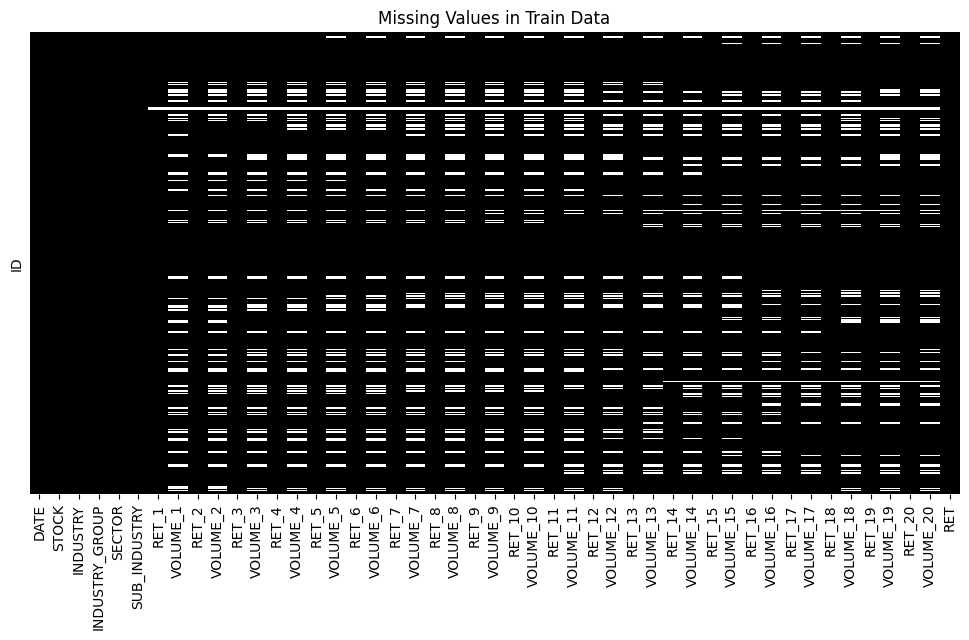

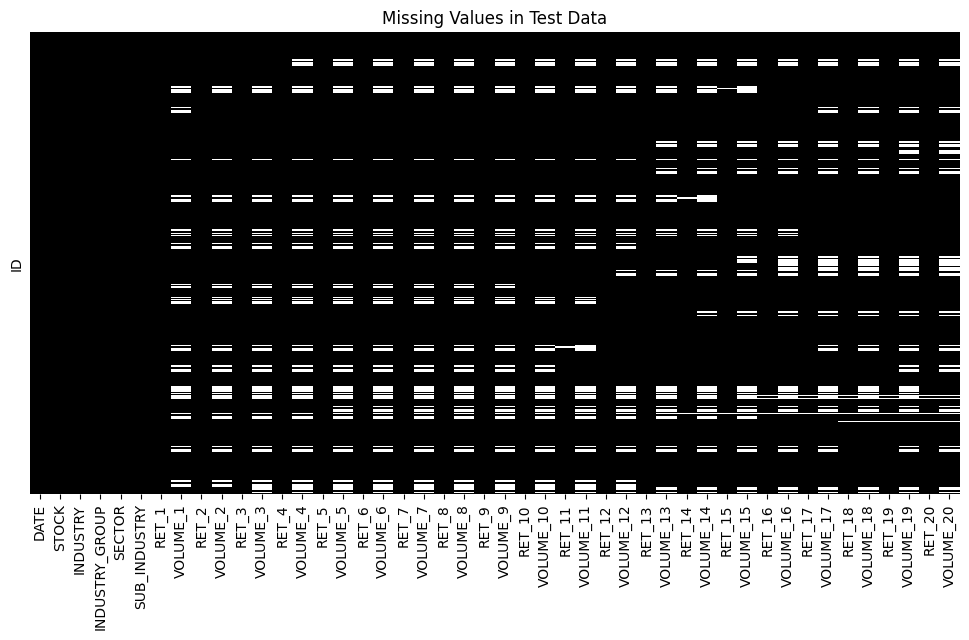

In [4]:
# Visualize missing values in the train and test datasets
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(train.isnull(), cbar=False, yticklabels=False, cmap='gray')
plt.title('Missing Values in Train Data')
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(test.isnull(), cbar=False, yticklabels=False, cmap='gray')
plt.title('Missing Values in Test Data')
plt.show()

In [5]:
# Handle missing values:
# - Drop rows with any missing RET_1 to RET_20 in both train and test
# - Fill missing VOLUME with mean by INDUSTRY_GROUP and DATE

ret_cols = [f'RET_{i+1}' for i in range(20)]
vol_cols = [f'VOLUME_{i+1}' for i in range(20)]

def drop_missing_ret(df, name=""):
    original_rows = len(df)
    df_clean = df.dropna(subset=ret_cols)
    rows_dropped = original_rows - len(df_clean)
    percent_dropped = 100 * rows_dropped / original_rows
    print(f"{name} Rows dropped due to RET missing: {rows_dropped} ({percent_dropped:.2f}%)")
    return df_clean

train = drop_missing_ret(train, "Train")
test = drop_missing_ret(test, "Test")

# Fill missing VOLUME with mean by INDUSTRY_GROUP and DATE
for col in vol_cols:
    train[col] = train.groupby(['INDUSTRY_GROUP', 'DATE'])[col].transform(lambda x: x.fillna(x.mean()))
    test[col] = test.groupby(['INDUSTRY_GROUP', 'DATE'])[col].transform(lambda x: x.fillna(x.mean()))

Train Rows dropped due to RET missing: 6126 (1.46%)
Test Rows dropped due to RET missing: 4494 (2.26%)


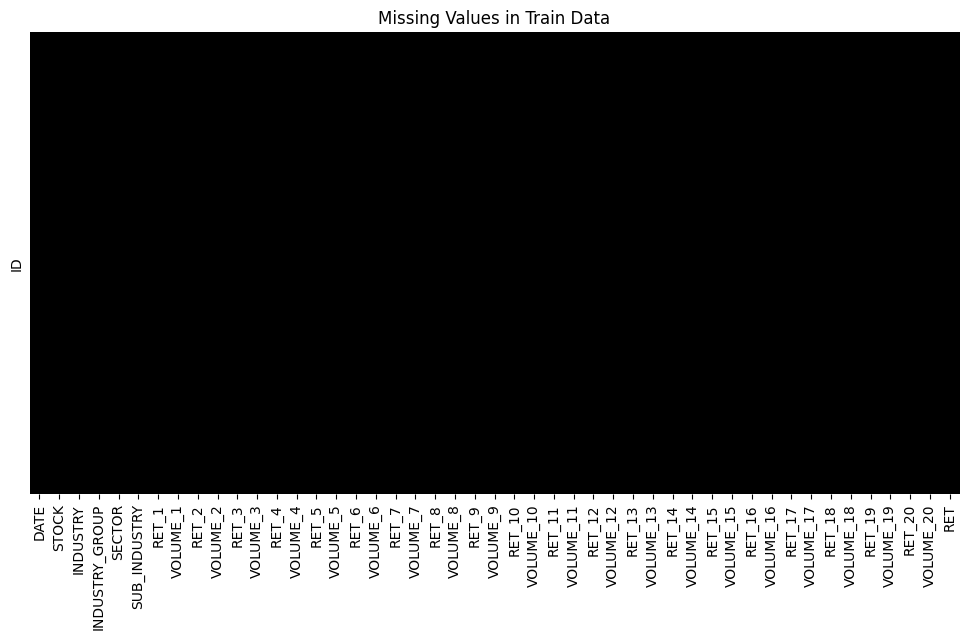

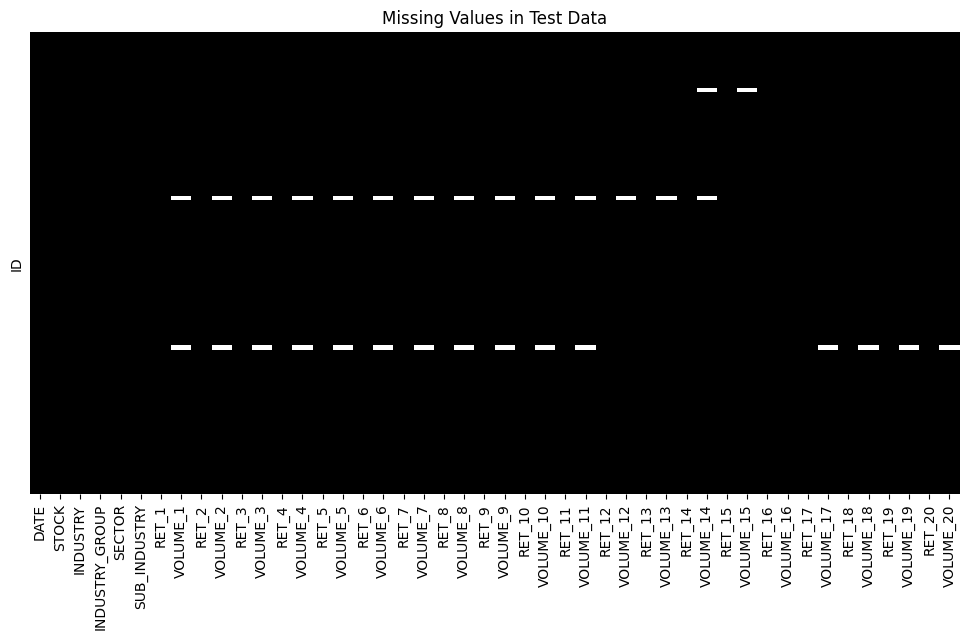

In [6]:
# Check for missing values
plt.figure(figsize=(12, 6))
sns.heatmap(train.isnull(), cbar=False, yticklabels=False, cmap='gray')
plt.title('Missing Values in Train Data')
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(test.isnull(), cbar=False, yticklabels=False, cmap='gray')
plt.title('Missing Values in Test Data')
plt.show()

### Data Visualisation

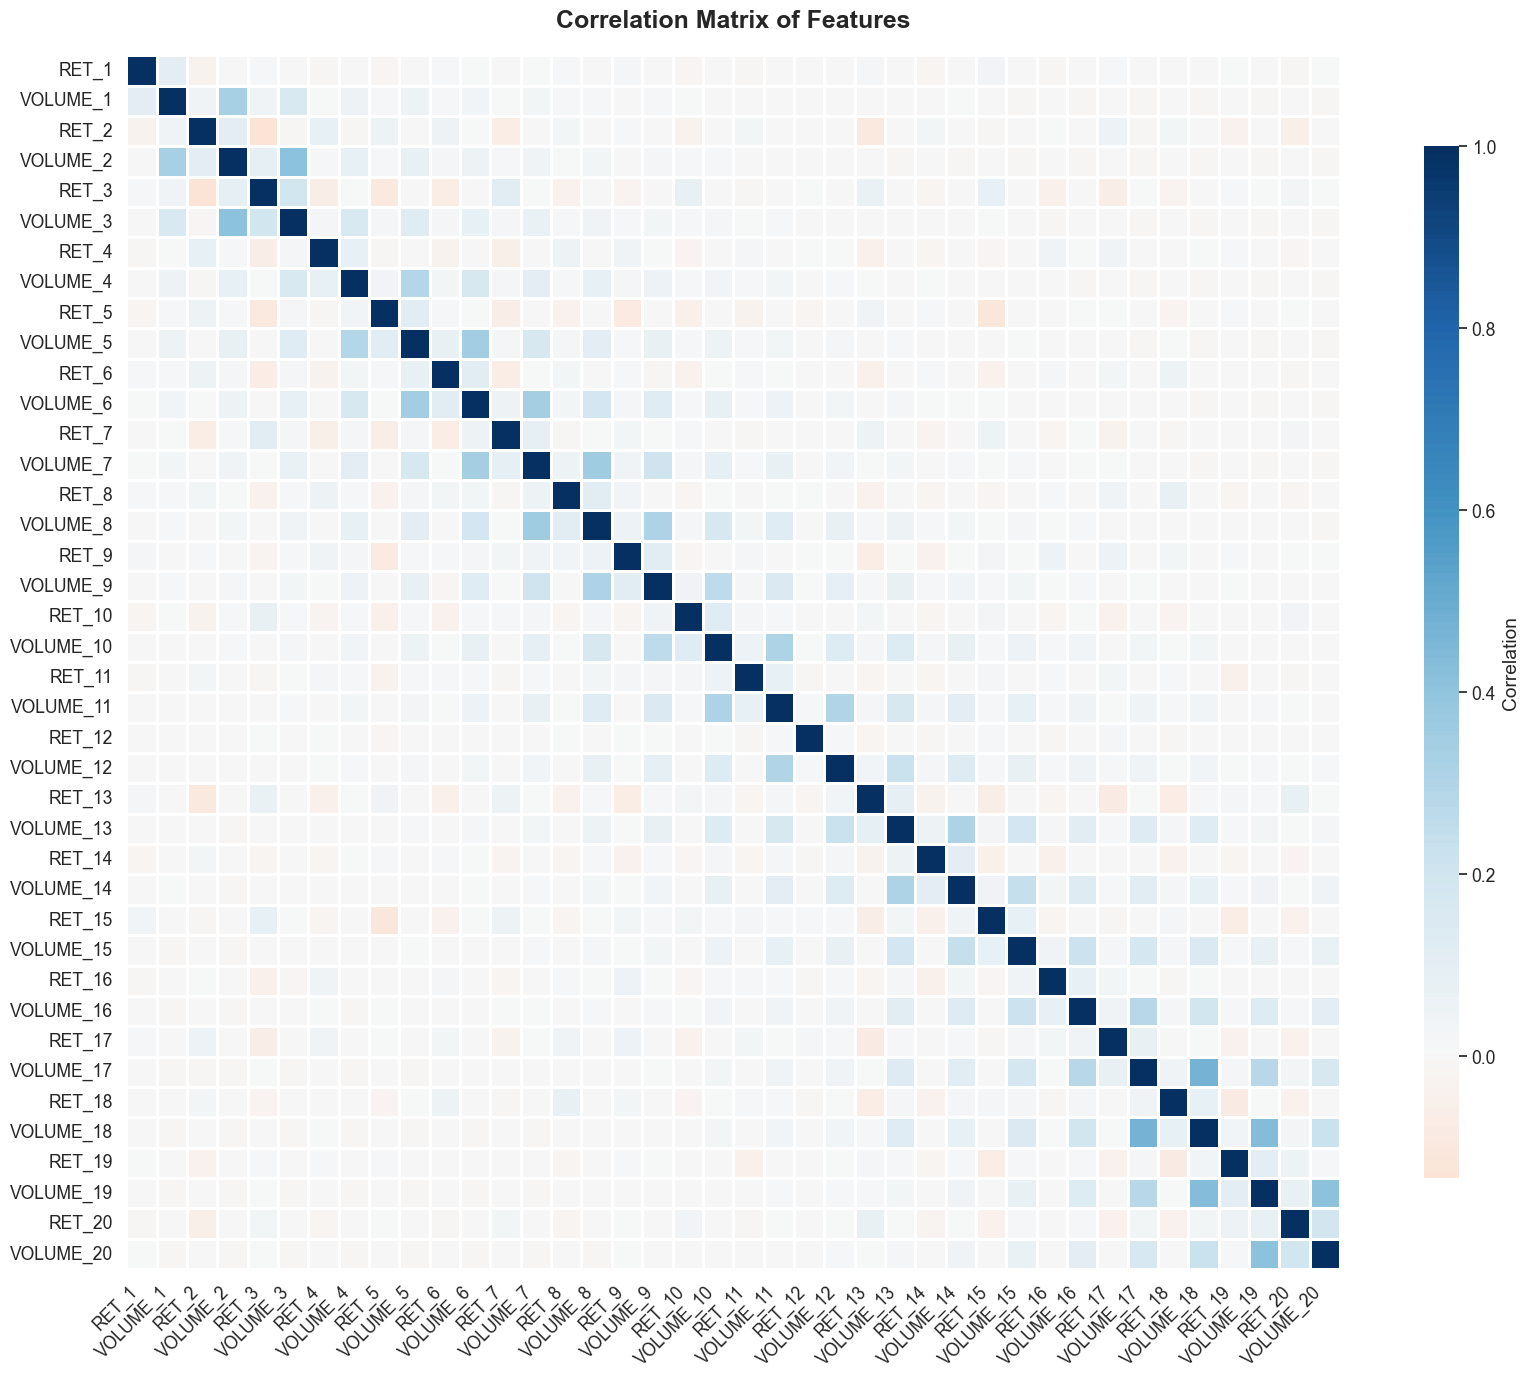

In [7]:
# Correlation matrix
orig_num_cols = [col for col in train.columns if col.startswith('RET_') or col.startswith('VOLUME_')]
corr_matrix_orig = train[orig_num_cols].corr()

plt.figure(figsize=(18, 14))
sns.set(style="white", font_scale=1.15)
sns.heatmap(
    corr_matrix_orig,
    cmap='RdBu',
    center=0,
    annot=False,
    fmt=".2f",
    linewidths=1,
    linecolor='white',
    square=True,
    cbar_kws={'shrink': 0.85, 'aspect': 30, 'label': 'Correlation'}
)
plt.title('Correlation Matrix of Features', fontsize=18, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


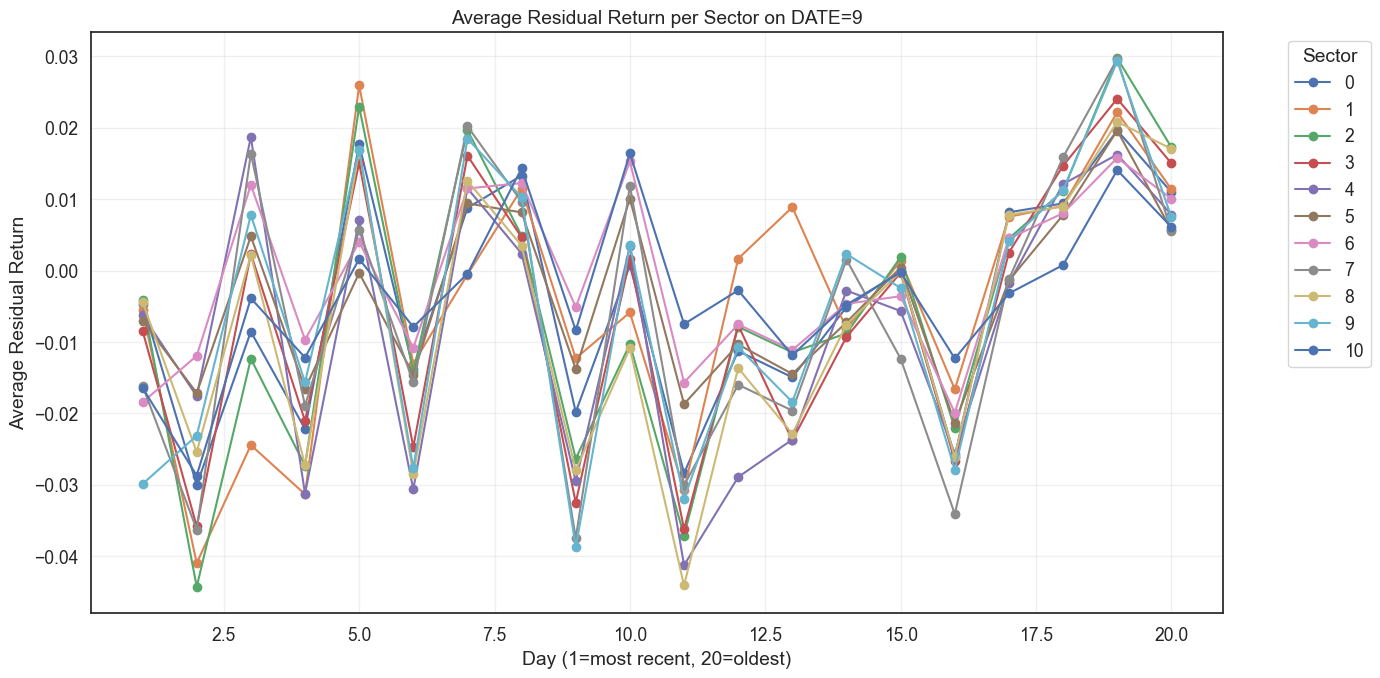

In [8]:
## Time series analysis of the average stock residual return of each sector

def plot_sector_avg_returns(train, date_value):
    # Filter for the given date
    df = train[train['DATE'] == date_value]
    if df.empty:
        print("No data for this date.")
        return

    ret_cols = [f'RET_{i+1}' for i in range(20) if f'RET_{i+1}' in df.columns]
    # Compute sector-wise average for each RET_k
    sector_means = df.groupby('SECTOR')[ret_cols].mean()

    # Plot
    plt.figure(figsize=(14, 7))
    for sector in sector_means.index:
        plt.plot(range(1, len(ret_cols)+1), sector_means.loc[sector], marker='o', label=sector)
    plt.title(f"Average Residual Return per Sector on DATE={date_value}")
    plt.xlabel("Day (1=most recent, 20=oldest)")
    plt.ylabel("Average Residual Return")
    plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_sector_avg_returns(train, date_value=9)

In [9]:
# Show the unique counts for each level in the hierarchy
print("Unique SECTORs:", train['SECTOR'].nunique())
print("Unique INDUSTRY_GROUPs:", train['INDUSTRY_GROUP'].nunique())
print("Unique INDUSTRYs:", train['INDUSTRY'].nunique())
print("Unique SUB_INDUSTRYs:", train['SUB_INDUSTRY'].nunique())

Unique SECTORs: 12
Unique INDUSTRY_GROUPs: 26
Unique INDUSTRYs: 72
Unique SUB_INDUSTRYs: 175


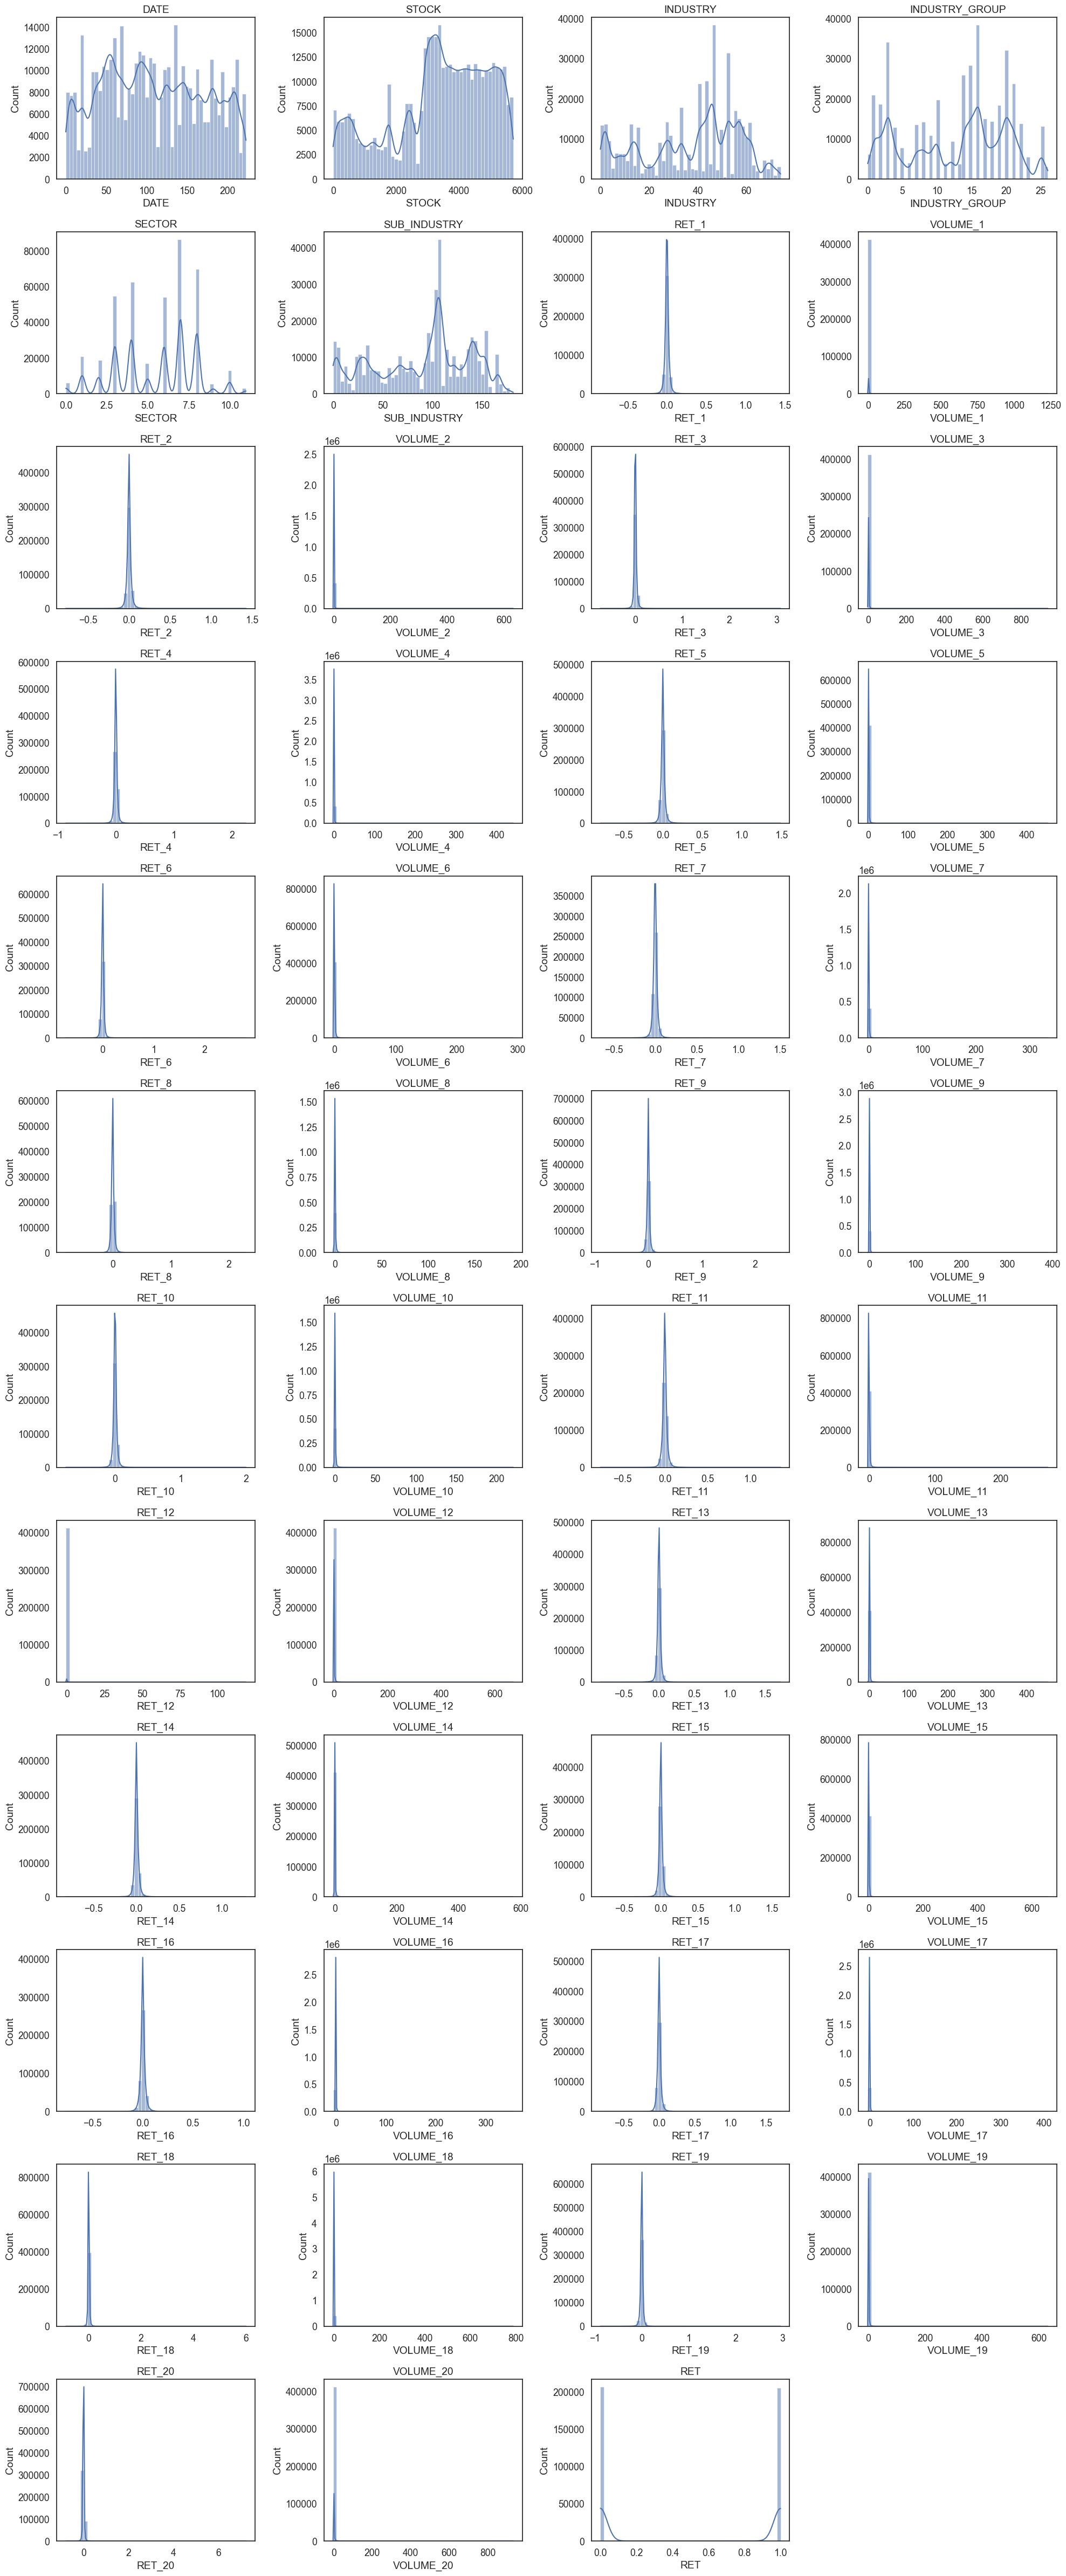

In [10]:
# Show distributions for all columns in train
n_plot = len(train.columns)
n_cols = 4
n_rows = (n_plot + n_cols - 1) // n_cols

plt.figure(figsize=(5 * n_cols, 4 * n_rows))
for i, col in enumerate(train.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(train[col], bins=50, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

## Feature Engineering

To enhance the model's ability to capture predictive signals from stock return behavior, we created several technical indicators derived from the 20-day residual return history of each stock. These features are designed to reflect trend dynamics, relative performance across groups, momentum, and volatility—core elements often used in quantitative finance.

### Moving Averages (MA)

We computed simple moving averages over 5-day and 10-day windows. For each window size, we generated multiple lagged features by sliding the window across different positions within the 20-day return history. This produced features such as `RET_MA5_1`, `RET_MA5_2`, ..., which represent the average return over consecutive subsets of past days. These features help the model detect short- and medium-term trends.

### Group-Based Relative Returns

For each of the 20 days, we calculated the average return of all stocks within the same `SECTOR` and `INDUSTRY_GROUP`, grouped by `DATE`. These features (`RET_IN_SECTOR_k` and `RET_IN_GROUP_k`) capture how a given stock's return compares to its peers on the same day, adding contextual, cross-sectional information that reflects industry-wide movements or sector-specific behavior.

### Exponential Moving Averages (EMA)

We added exponentially weighted moving averages with spans of 5 and 10 days to capture trend sensitivity while emphasizing recent returns. The EMA series was built in forward order, starting from `RET_1`, recursively applying the smoothing factor to generate lagged EMA features (`RET_EMA5_k`, `RET_EMA10_k`). These indicators respond more quickly to recent return changes than simple moving averages.

### MACD

We computed a Moving Average Convergence Divergence (MACD)-like feature by subtracting the 10-day EMA from the 5-day EMA for each valid time step. These MACD features (`RET_MACD_k`) help capture changes in return momentum and potential trend reversals.

### Volatility

A volatility measure was included by computing the standard deviation across all 20 residual return values for each stock. This global feature (`VOLATILITY`) provides information on how stable or erratic a stock’s returns have been in the recent past, which may correlate with risk or upcoming directional shifts.

All features were engineered using efficient vectorized operations in pandas and appended to both the training and test datasets to enrich the input space for the model.

In [11]:
def add_technical_features(df):
    N_MA = [5, 10]
    N_EMA = [5, 10]
    n_ret = 20
    features = {}

    # Moving averages
    for N in N_MA:
        for shift in range(n_ret - N):
            cols = [f'RET_{n+shift+1}' for n in range(N)]
            if all(col in df.columns for col in cols):
                features[f'RET_MA{N}_{shift+1}'] = df[cols].mean(axis=1)

    # Sector and industry group means
    for n in range(n_ret):
        col = f'RET_{n+1}'
        if col in df.columns:
            features[f'RET_IN_SECTOR_{n+1}'] = df.groupby(['DATE', 'SECTOR'])[col].transform('mean')
            features[f'RET_IN_GROUP_{n+1}'] = df.groupby(['DATE', 'INDUSTRY_GROUP'])[col].transform('mean')

   # Exponential moving averages (standard initialization)
    for n_ema in N_EMA:
        alpha = 2 / (n_ema + 1)
        # Initialize EMA with RET_1
        if f'RET_1' in df.columns:
            features[f'RET_EMA{n_ema}_1'] = df['RET_1']
            for n in range(1, n_ret):
                col = f'RET_{n+1}'
                prev_ema = f'RET_EMA{n_ema}_{n}'
                if col in df.columns and prev_ema in features:
                    features[f'RET_EMA{n_ema}_{n+1}'] = df[col] * alpha + features[prev_ema] * (1 - alpha)

    # MACD
    for n in range(19):
        ema_long = f'RET_EMA{N_EMA[1]}_{n+1}'
        ema_short = f'RET_EMA{N_EMA[0]}_{n+1}'
        if ema_long in features and ema_short in features:
            features[f'RET_MACD_{n+1}'] = features[ema_long] - features[ema_short]

    # Volatility
    ret_cols = [f'RET_{i+1}' for i in range(n_ret) if f'RET_{i+1}' in df.columns]
    if ret_cols:
        features['VOLATILITY'] = df[ret_cols].std(axis=1)

   # Add features directly to avoid duplicate columns
    for key, value in features.items():
        df[key] = value
    return df

# Apply to both train and test
train = add_technical_features(train)
test = add_technical_features(test)

/var/folders/tp/j_rkz46n6z519dkc3t08mt500000gn/T/ipykernel_47188/4251208461.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[key] = value
/var/folders/tp/j_rkz46n6z519dkc3t08mt500000gn/T/ipykernel_47188/4251208461.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[key] = value
/var/folders/tp/j_rkz46n6z519dkc3t08mt500000gn/T/ipykernel_47188/4251208461.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

## Feature Selection

After constructing a diverse set of engineered features, we proceeded to select the most informative inputs for modeling. Our selection focused on a blend of raw historical signals, sector-aware context, and technical indicators, with an emphasis on the most recent observations.

### Historical and Technical Features

We retained the most recent **5 days** of historical values (`RET_1` to `RET_5` and `VOLUME_1` to `VOLUME_5`), which capture short-term behavior in returns and trading activity. In addition, we included group-based features (`RET_IN_SECTOR_k`) that measure sector-level performance for the same time period, allowing the model to understand a stock's relative behavior in its market segment.

### Moving Averages and Momentum

We selected several technical indicators:
- **Moving Averages (MA)**: Lagged 5-day and 10-day moving averages for the recent days (`RET_MA5_k`, `RET_MA10_k`) help the model detect upward or downward trends.
- **Exponential Moving Averages (EMA)**: EMA features (`RET_EMA5_k`, `RET_EMA10_k`) provide more reactive trend signals by assigning exponentially decreasing weights to older returns.
- **MACD**: The MACD-like features (`RET_MACD_k`) were included to capture momentum shifts, defined as the difference between short- and long-term EMAs.

### Volatility and Additional Features

We included a global **volatility measure**, computed as the standard deviation of the 20-day return window, to capture how stable or erratic a stock has been over the recent period. We also accounted for any additional custom features (via the `new_features` list), provided they were unique and available in the data.

### Final Selection and Filtering

To ensure compatibility with downstream modeling, we filtered the final list of selected features to include only columns present in the training dataset. This eliminated the risk of referencing missing or improperly generated features.

In [12]:
# Feature selection based on historical values and engineered features
try:
    new_features
except NameError:
    new_features = []
    
N_HIST = 5
N_MA = [5, 10]
N_EMA = [5, 10]

features = []
features.append('VOLATILITY')
for n in range(N_HIST):
    features.append(f'RET_{n+1}')
    features.append(f'VOLUME_{n+1}')
    features.append(f'RET_IN_SECTOR_{n+1}')
    for n_ma in N_MA:
        if 20 - n_ma > n:
            features.append(f'RET_MA{n_ma}_{n+1}')
    for n_ema in N_EMA:
        if n + 1 < 20:
            features.append(f'RET_EMA{n_ema}_{n+1}')
    if n + 1 < 20:
        features.append(f'RET_MACD_{n+1}')

# Optionally, add any additional features (e.g., from new_features list)
features += [f for f in new_features if f not in features]

# Keep only features that exist in the dataframe
features = [f for f in features if f in train.columns]

print(f'No. of features: {len(features)}\n\nList of features:\n{features}')

# Preview the selected features
train[features].head()

No. of features: 41

List of features:
['VOLATILITY', 'RET_1', 'VOLUME_1', 'RET_IN_SECTOR_1', 'RET_MA5_1', 'RET_MA10_1', 'RET_EMA5_1', 'RET_EMA10_1', 'RET_MACD_1', 'RET_2', 'VOLUME_2', 'RET_IN_SECTOR_2', 'RET_MA5_2', 'RET_MA10_2', 'RET_EMA5_2', 'RET_EMA10_2', 'RET_MACD_2', 'RET_3', 'VOLUME_3', 'RET_IN_SECTOR_3', 'RET_MA5_3', 'RET_MA10_3', 'RET_EMA5_3', 'RET_EMA10_3', 'RET_MACD_3', 'RET_4', 'VOLUME_4', 'RET_IN_SECTOR_4', 'RET_MA5_4', 'RET_MA10_4', 'RET_EMA5_4', 'RET_EMA10_4', 'RET_MACD_4', 'RET_5', 'VOLUME_5', 'RET_IN_SECTOR_5', 'RET_MA5_5', 'RET_MA10_5', 'RET_EMA5_5', 'RET_EMA10_5', 'RET_MACD_5']


,VOLATILITY,RET_1,VOLUME_1,RET_IN_SECTOR_1,RET_MA5_1,RET_MA10_1,RET_EMA5_1,RET_EMA10_1,RET_MACD_1,RET_2,...,RET_EMA10_4,RET_MACD_4,RET_5,VOLUME_5,RET_IN_SECTOR_5,RET_MA5_5,RET_MA10_5,RET_EMA5_5,RET_EMA10_5,RET_MACD_5
ID,,,,,,,,,,,,,,,,,,,,,
0,0.054646,-0.015748,0.147931,0.009178,-0.003694,0.027665,-0.015748,-0.015748,0.0,-0.015504,...,-0.011548,-0.002132,0.016483,-0.972920,0.005187,0.025863,0.033353,-0.000782,-0.006451,-0.005669
1,0.048808,0.003984,0.042790,0.006450,-0.026274,0.006335,0.003984,0.003984,0.0,-0.090580,...,-0.010686,0.005883,-0.038062,-0.236635,0.005564,0.022202,0.004877,-0.023733,-0.015663,0.008070
2,0.023417,0.000440,-0.096282,0.013335,-0.006658,0.001767,0.000440,0.000440,0.0,-0.058896,...,-0.003754,-0.001434,0.009354,0.091455,0.023351,0.000902,0.006351,0.001571,-0.001371,-0.002942
3,0.020831,0.031298,-0.429540,0.017253,0.003658,-0.003982,0.031298,0.031298,0.0,0.007756,...,0.013820,0.010985,0.003544,-0.882464,-0.009513,-0.006524,-0.004920,0.003071,0.011951,0.008880
4,0.032045,0.027273,-0.847155,0.006417,0.002059,-0.000206,0.027273,0.027273,0.0,-0.039302,...,0.010154,0.007896,0.022321,-1.204398,0.001654,-0.002411,0.005111,0.008946,0.012366,0.003420


## Data Normalization and Standardization

To prepare the data for training, we applied standard normalization to the selected features. Using `StandardScaler` from `scikit-learn`, we standardized each feature to have **zero mean and unit variance**. This step is especially important when using distance-sensitive models or regularization-based algorithms, as it ensures all features contribute equally to the optimization process.

- The scaler was fit on the **training set only** to avoid data leakage.
- Both `X_train` and `X_test` were transformed using the same fitted scaler to ensure consistency.
- The target variable `y_train` was extracted directly from the `RET` column, which represents the binary sign of the residual return.

This normalization step completes the preprocessing pipeline, setting the stage for model training and evaluation on a clean, standardized feature set.

In [13]:
# Data normalization and standardization

from sklearn.preprocessing import StandardScaler

# y is the target column from the DataFrame
y = train['RET'].values

# Fit scaler on features
scaler = StandardScaler()
scaler.fit(train[features])

# Store scaled features in new variables
X_train = scaler.transform(train[features])
X_test = scaler.transform(test[features])
y_train = train['RET'].values

## Machine Learning Models

To predict the binary sign of residual stock returns, we experimented with a variety of supervised learning models, each trained and evaluated using cross-validation techniques that respected the temporal structure of the data.

### Random Forest

We first implemented a **Random Forest classifier** with 500 trees and a maximum depth of 10. To avoid data leakage and reflect the time-sensitive nature of financial data, we used a 4-fold cross-validation scheme where splits were made based on unique `DATE` values. Within each fold, predictions were post-processed using a median-based threshold per date, converting probability scores into binary outcomes. The model achieved consistent performance across folds, with average accuracy reported alongside standard deviation. Feature importances were also analyzed to highlight the most informative variables.

### Neural Network

We then built a **fully connected feedforward neural network** using TensorFlow/Keras. The architecture included:
- A first dense layer with 150 neurons (tanh activation) and L2 regularization,
- Two hidden layers (50 and 35 neurons respectively) with ReLU activations,
- Batch normalization and dropout (up to 50%) for regularization,
- A final sigmoid output for binary classification.

Training was performed using the Adam optimizer and binary cross-entropy loss, with early stopping based on validation loss. We monitored both training and validation losses to assess convergence and prevent overfitting. The final model was evaluated using accuracy, precision, recall, and F1-score.

### XGBoost

We also employed **XGBoost**, a gradient boosting method known for its performance on structured data. We used 4-fold **GroupKFold cross-validation** grouped by `DATE`. The model was configured with 100 trees, a maximum depth of 4, and a learning rate of 0.05. Evaluation metrics included accuracy and ROC AUC, as well as confusion matrices and detailed classification reports for each fold.

### CatBoost

In parallel, we trained a **CatBoost classifier**, which is well-suited for categorical data and offers robust performance with minimal tuning. Using the same `DATE`-based GroupKFold strategy, the CatBoost model was trained for up to 200 iterations with early stopping. Evaluation mirrored that of the XGBoost model, capturing metrics like accuracy, AUC, and per-class performance.

### Ensemble Learning

To leverage the strengths of each model, we created a **weighted ensemble** that combines predictions from:
- Random Forest,
- XGBoost,
- CatBoost,
- Neural Network.

Each model contributed equally (25%) to the final ensemble probability prediction. The binary decision was made using a threshold of 0.5. The ensemble outperformed individual models in terms of accuracy and AUC on the training set and is a promising approach for test-time inference.

---

By combining multiple models and using a time-aware evaluation strategy, we developed a robust pipeline capable of extracting signal from high-dimensional, noisy financial data. The ensemble's performance highlights the value of integrating diverse modeling approaches in a structured and statistically sound way.

In [14]:
from sklearn.metrics import accuracy_score, classification_report

target = 'RET'

rf_params = {
    'n_estimators': 500,
    'max_depth': 10,
    'random_state': 0,
    'n_jobs': -1
}

train_dates = train['DATE'].unique()
n_splits = 4
scores = []
models = []

splits = KFold(n_splits=n_splits, random_state=0, shuffle=True).split(train_dates)

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = train['DATE'].isin(local_train_dates)
    local_test_ids = train['DATE'].isin(local_test_dates)

    # Use boolean indexing on the original DataFrame to get row indices
    train_idx = np.where(local_train_ids)[0]
    test_idx = np.where(local_test_ids)[0]

    X_local_train = X_train[train_idx]
    y_local_train = y_train[train_idx]
    X_local_test = X_train[test_idx]
    y_local_test = y_train[test_idx]

    # No fillna needed for NumPy arrays from StandardScaler

    model = RandomForestClassifier(**rf_params)
    model.fit(X_local_train, y_local_train)

    y_local_pred = model.predict_proba(X_local_test)[:, 1]

    sub = train.iloc[test_idx].copy()
    sub['pred'] = y_local_pred
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score*100:.2f}%")

mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')


Fold 1 - Accuracy: 51.26%
Fold 2 - Accuracy: 51.17%
Fold 3 - Accuracy: 53.34%
Fold 4 - Accuracy: 52.24%
Accuracy: 52.00% [51.12 ; 52.88] (+- 0.88)


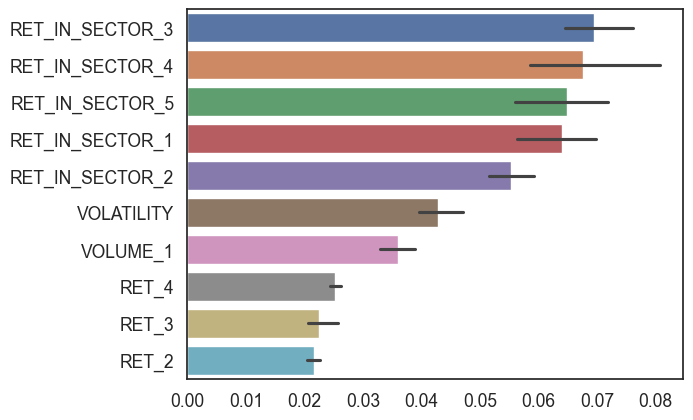

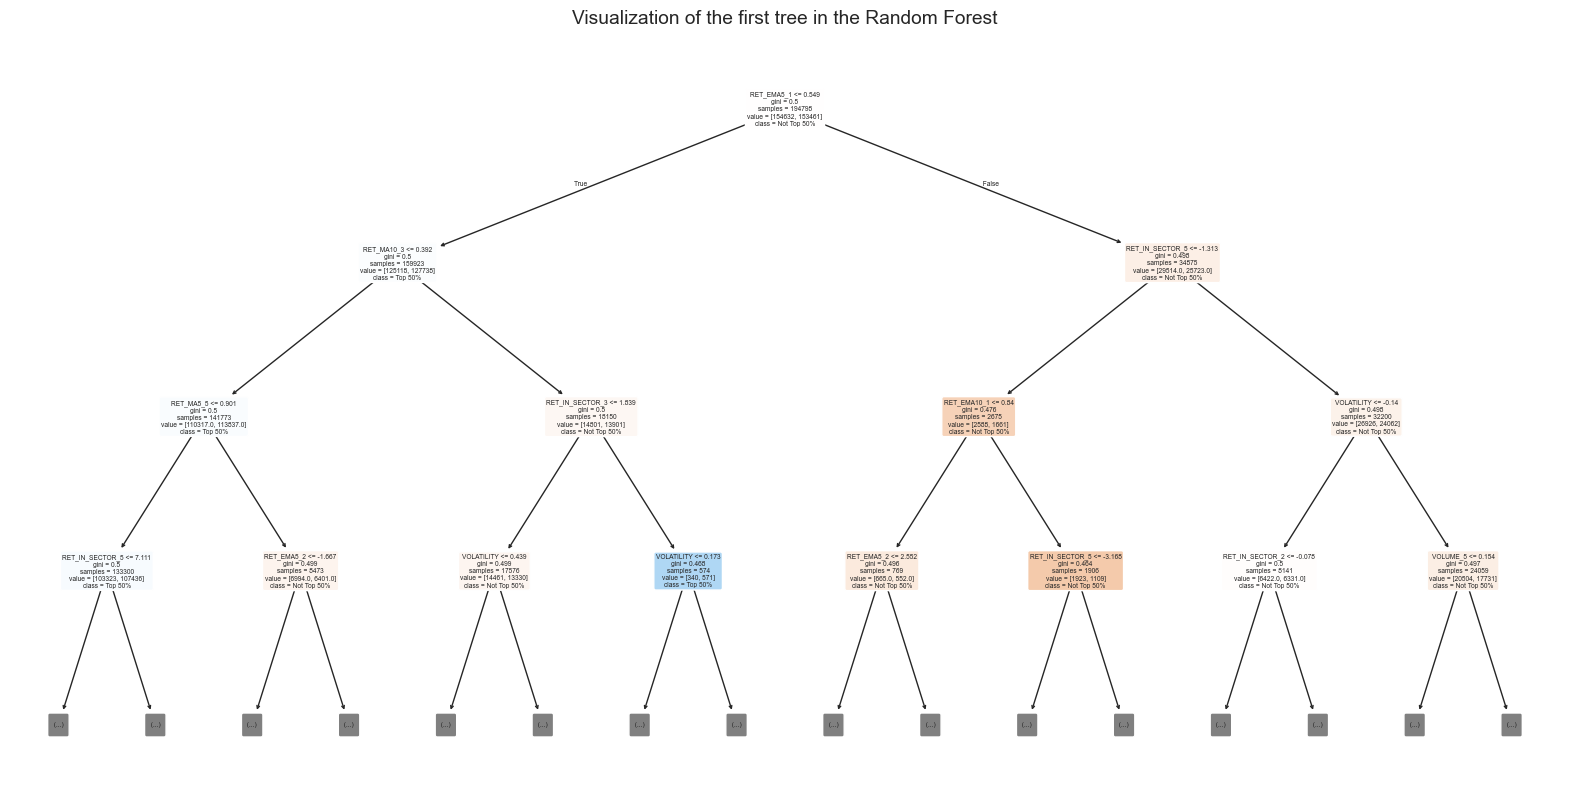

In [15]:
# Feature importances
feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=features)

# Get the top 10 features by mean importance
top_features = feature_importances.mean().sort_values(ascending=False).head(10).index   

sns.barplot(
    data=feature_importances[top_features],
    orient='h',
    order=top_features
)

# Visualize the first tree from the first trained Random Forest model
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Pick the first model from cross-validation
rf_model = models[0]

plt.figure(figsize=(20, 10))
plot_tree(
    rf_model.estimators_[0],
    feature_names=features,
    class_names=['Not Top 50%', 'Top 50%'],
    filled=True,
    rounded=True,
    max_depth=3  # Limit depth for readability
)
plt.title("Visualization of the first tree in the Random Forest")
plt.show()

Epoch 1/20


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5801/5801 - 4s - 696us/step - accuracy: 0.5059 - loss: 0.7250 - val_accuracy: 0.5029 - val_loss: 0.7059
Epoch 2/20
5801/5801 - 3s - 567us/step - accuracy: 0.5145 - loss: 0.7002 - val_accuracy: 0.5067 - val_loss: 0.6969
Epoch 3/20
5801/5801 - 3s - 575us/step - accuracy: 0.5172 - loss: 0.6951 - val_accuracy: 0.5070 - val_loss: 0.6952
Epoch 4/20
5801/5801 - 3s - 568us/step - accuracy: 0.5176 - loss: 0.6939 - val_accuracy: 0.5060 - val_loss: 0.6953
Epoch 5/20
5801/5801 - 3s - 566us/step - accuracy: 0.5191 - loss: 0.6936 - val_accuracy: 0.5063 - val_loss: 0.6949
Epoch 6/20
5801/5801 - 3s - 569us/step - accuracy: 0.5192 - loss: 0.6934 - val_accuracy: 0.5030 - val_loss: 0.6947
Epoch 7/20
5801/5801 - 3s - 557us/step - accuracy: 0.5196 - loss: 0.6934 - val_accuracy: 0.5004 - val_loss: 0.6954
Epoch 8/20
5801/5801 - 3s - 556us/step - accuracy: 0.5198 - loss: 0.6934 - val_accuracy: 0.5005 - val_loss: 0.6954
Epoch 9/20
5801/5801 - 3s - 556us/step - accuracy: 0.5203 - loss: 0.6933 - val_accuracy: 0.

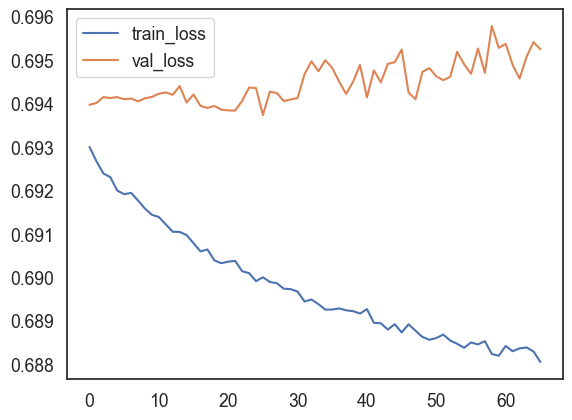

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

# Neural network construction
input_dim = X_train.shape[1]

# Convert y_train to integer type for binary classification
y_train = y_train.astype(int)

# --- Representative validation split based on DATE ---
unique_dates = np.sort(train['DATE'].unique())
n_val_dates = int(0.1 * len(unique_dates))
val_dates = unique_dates[-n_val_dates:]

val_mask = train['DATE'].isin(val_dates)
train_mask = ~val_mask

X_nn_train = X_train[train_mask]
y_nn_train = y_train[train_mask]
X_nn_val = X_train[val_mask]
y_nn_val = y_train[val_mask]

# Define the neural network model
nn_model = Sequential([
    Dense(150, activation='tanh', kernel_regularizer=l2(1e-4), input_shape=(input_dim,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(50, activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(35, activation='relu', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])


# Choices for loss, metrics, and optimizer
nn_model.compile(
    optimizer=Adam(learning_rate=0.0005),      # Adam optimizer with a learning rate of 0.0005
    loss='binary_crossentropy',               # Classical loss for binary classification
    metrics=['accuracy']                      # Classical metric for classification
)

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=40,
    restore_best_weights=True
)

# Fit the model (adjust epochs and batch_size as needed)
history = nn_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    verbose=2,
    callbacks=[early_stop]
)

# Train the neural network model for 250 epochs and batch size of 5000
history_long = nn_model.fit(
    X_train, y_train,
    epochs=250,
    batch_size=5000,
    validation_split=0.1,
    verbose=2,
    callbacks=[early_stop]
)

from sklearn.metrics import classification_report

# Predict probabilities and convert to binary predictions
y_pred_prob = nn_model.predict(X_train)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Print classification report (includes accuracy, precision, recall, f1-score)
print(classification_report(y_train, y_pred, digits=4))

import matplotlib.pyplot as plt
plt.plot(history_long.history['loss'], label='train_loss')
plt.plot(history_long.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [17]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import GroupKFold
import numpy as np

# Use GroupKFold by DATE for robust cross-validation
n_splits = 4
group_kfold = GroupKFold(n_splits=n_splits)
groups = train['DATE'].values

accuracies = []
aucs = []
all_reports = []
all_conf_matrices = []

for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X_train, y_train, groups)):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    xgb_model = XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=fold,
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    xgb_model.fit(X_tr, y_tr)

    y_val_pred_prob = xgb_model.predict_proba(X_val)[:, 1]
    y_val_pred = (y_val_pred_prob > 0.5).astype(int)

    acc = accuracy_score(y_val, y_val_pred)
    auc = roc_auc_score(y_val, y_val_pred_prob)
    report = classification_report(y_val, y_val_pred, digits=4)
    conf_matrix = confusion_matrix(y_val, y_val_pred)

    accuracies.append(acc)
    aucs.append(auc)
    all_reports.append(report)
    all_conf_matrices.append(conf_matrix)

    print(f"\nFold {fold+1}:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  ROC AUC: {auc:.4f}")
    print("  Classification Report:")
    print(report)
    print("  Confusion Matrix:")
    print(conf_matrix)

print(f"\nMean Accuracy: {np.mean(accuracies):.4f} (+/- {np.std(accuracies):.4f})")
print(f"Mean ROC AUC: {np.mean(aucs):.4f} (+/- {np.std(aucs):.4f})")

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:36:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Fold 1:
  Accuracy: 0.5165
  ROC AUC: 0.5223
  Classification Report:
              precision    recall  f1-score   support

           0     0.5183    0.4825    0.4997     51886
           1     0.5149    0.5506    0.5321     51771

    accuracy                         0.5165    103657
   macro avg     0.5166    0.5165    0.5159    103657
weighted avg     0.5166    0.5165    0.5159    103657

  Confusion Matrix:
[[25033 26853]
 [23267 28504]]


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:36:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Fold 2:
  Accuracy: 0.5151
  ROC AUC: 0.5201
  Classification Report:
              precision    recall  f1-score   support

           0     0.5137    0.5919    0.5500     50811
           1     0.5171    0.4381    0.4743     50674

    accuracy                         0.5151    101485
   macro avg     0.5154    0.5150    0.5122    101485
weighted avg     0.5154    0.5151    0.5122    101485

  Confusion Matrix:
[[30076 20735]
 [28472 22202]]


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:36:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Fold 3:
  Accuracy: 0.5210
  ROC AUC: 0.5281
  Classification Report:
              precision    recall  f1-score   support

           0     0.5263    0.4685    0.4957     52087
           1     0.5168    0.5741    0.5439     51569

    accuracy                         0.5210    103656
   macro avg     0.5215    0.5213    0.5198    103656
weighted avg     0.5215    0.5210    0.5197    103656

  Confusion Matrix:
[[24402 27685]
 [21964 29605]]


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:36:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Fold 4:
  Accuracy: 0.5001
  ROC AUC: 0.5013
  Classification Report:
              precision    recall  f1-score   support

           0     0.5019    0.5113    0.5065     52023
           1     0.4983    0.4889    0.4935     51648

    accuracy                         0.5001    103671
   macro avg     0.5001    0.5001    0.5000    103671
weighted avg     0.5001    0.5001    0.5001    103671

  Confusion Matrix:
[[26598 25425]
 [26397 25251]]

Mean Accuracy: 0.5132 (+/- 0.0079)
Mean ROC AUC: 0.5180 (+/- 0.0100)


In [18]:
# Catboost modelfrom catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import GroupKFold
from catboost import CatBoostClassifier
import numpy as np

# Use GroupKFold by DATE for robust cross-validation
n_splits = 4
group_kfold = GroupKFold(n_splits=n_splits)
groups = train['DATE'].values

cat_accuracies = []
cat_aucs = []
cat_all_reports = []
cat_all_conf_matrices = []

for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X_train, y_train, groups)):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    cat_model = CatBoostClassifier(
        iterations=200,
        depth=4,
        learning_rate=0.05,
        subsample=0.8,
        random_state=fold,
        verbose=0,
        eval_metric='Logloss'
    )
    cat_model.fit(X_tr, y_tr, eval_set=(X_val, y_val), early_stopping_rounds=20)

    y_val_pred_prob = cat_model.predict_proba(X_val)[:, 1]
    y_val_pred = (y_val_pred_prob > 0.5).astype(int)

    acc = accuracy_score(y_val, y_val_pred)
    auc = roc_auc_score(y_val, y_val_pred_prob)
    report = classification_report(y_val, y_val_pred, digits=4)
    conf_matrix = confusion_matrix(y_val, y_val_pred)

    cat_accuracies.append(acc)
    cat_aucs.append(auc)
    cat_all_reports.append(report)
    cat_all_conf_matrices.append(conf_matrix)

    print(f"\nCatBoost Fold {fold+1}:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  ROC AUC: {auc:.4f}")
    print("  Classification Report:")
    print(report)
    print("  Confusion Matrix:")
    print(conf_matrix)

print(f"\nCatBoost Mean Accuracy: {np.mean(cat_accuracies):.4f} (+/- {np.std(cat_accuracies):.4f})")
print(f"CatBoost Mean ROC AUC: {np.mean(cat_aucs):.4f} (+/- {np.std(cat_aucs):.4f})")


CatBoost Fold 1:
  Accuracy: 0.5238
  ROC AUC: 0.5312
  Classification Report:
              precision    recall  f1-score   support

           0     0.5241    0.5288    0.5265     51886
           1     0.5235    0.5188    0.5211     51771

    accuracy                         0.5238    103657
   macro avg     0.5238    0.5238    0.5238    103657
weighted avg     0.5238    0.5238    0.5238    103657

  Confusion Matrix:
[[27437 24449]
 [24911 26860]]

CatBoost Fold 2:
  Accuracy: 0.5245
  ROC AUC: 0.5319
  Classification Report:
              precision    recall  f1-score   support

           0     0.5225    0.5841    0.5516     50811
           1     0.5271    0.4648    0.4940     50674

    accuracy                         0.5245    101485
   macro avg     0.5248    0.5244    0.5228    101485
weighted avg     0.5248    0.5245    0.5228    101485

  Confusion Matrix:
[[29679 21132]
 [27123 23551]]

CatBoost Fold 3:
  Accuracy: 0.5198
  ROC AUC: 0.5269
  Classification Report:
    

In [23]:
# Create ensemble model predictions

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
import numpy as np

# --- Fit all models on the full training set ---

# 1. Random Forest
rf_full = RandomForestClassifier(**rf_params)
rf_full.fit(X_train, y_train)
rf_pred_prob = rf_full.predict_proba(X_train)[:, 1]
rf_pred_prob_test = rf_full.predict_proba(X_test)[:, 1]

# 2. XGBoost
xgb_full = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=0,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_full.fit(X_train, y_train)
xgb_pred_prob = xgb_full.predict_proba(X_train)[:, 1]
xgb_pred_prob_test = xgb_full.predict_proba(X_test)[:, 1]

# 3. CatBoost
cat_full = CatBoostClassifier(
    iterations=200,
    depth=4,
    learning_rate=0.05,
    subsample=0.8,
    random_state=0,
    verbose=0,
    eval_metric='Logloss'
)
cat_full.fit(X_train, y_train)
cat_pred_prob = cat_full.predict_proba(X_train)[:, 1]
cat_pred_prob_test = cat_full.predict_proba(X_test)[:, 1]

# 4. Neural Network (already trained as nn_model)
nn_pred_prob = nn_model.predict(X_train).flatten()
nn_pred_prob_test = nn_model.predict(X_test).flatten()

# --- Learn optimal weights using logistic regression (stacking) ---
meta_X = np.vstack([rf_pred_prob, xgb_pred_prob, cat_pred_prob, nn_pred_prob]).T
meta_y = y_train

meta_model = LogisticRegression()
meta_model.fit(meta_X, meta_y)

optimal_weights = meta_model.coef_[0]
optimal_weights = optimal_weights / optimal_weights.sum()  # Normalize to sum to 1
print("Optimal weights (RF, XGB, CAT, NN):", optimal_weights)

w_rf, w_xgb, w_cat, w_nn = optimal_weights

# --- Weighted Ensemble with learned weights ---
ensemble_pred_prob = (
    w_rf * rf_pred_prob +
    w_xgb * xgb_pred_prob +
    w_cat * cat_pred_prob +
    w_nn * nn_pred_prob
)

ensemble_pred = (ensemble_pred_prob > 0.5).astype(int)

# --- Evaluation on train ---
acc = accuracy_score(y_train, ensemble_pred)
auc = roc_auc_score(y_train, ensemble_pred_prob)
report = classification_report(y_train, ensemble_pred, digits=4)

print(f"Ensemble Accuracy: {acc:.4f}")
print(f"Ensemble ROC AUC: {auc:.4f}")
print("Classification Report:")
print(report)

# --- Ensemble Model Submission on test set ---
ensemble_pred_prob_test = (
    w_rf * rf_pred_prob_test +
    w_xgb * xgb_pred_prob_test +
    w_cat * cat_pred_prob_test +
    w_nn * nn_pred_prob_test
)

sub = test.copy()
sub['pred'] = ensemble_pred_prob_test
y_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

submission = pd.Series(y_pred)
submission.index = test.index
submission.name = target

submission.to_csv('./qrt_output_stock_return_prediction.csv', index=True, header=True)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:56:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


12890/12890 ━━━━━━━━━━━━━━━━━━━━ 2s 180us/step
6061/6061 ━━━━━━━━━━━━━━━━━━━━ 1s 179us/step


/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept


Optimal weights (RF, XGB, CAT, NN): [ 2.44979283 -0.33428907 -0.78392204 -0.33158172]
Ensemble Accuracy: 0.6155
Ensemble ROC AUC: 0.6709
Classification Report:
              precision    recall  f1-score   support

           0     0.6148    0.6246    0.6196    206807
           1     0.6163    0.6064    0.6113    205662

    accuracy                         0.6155    412469
   macro avg     0.6155    0.6155    0.6155    412469
weighted avg     0.6155    0.6155    0.6155    412469



/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


 ## Final Submission

In this final stage, we apply our trained models to the unseen test data to generate predictions for submission. We use the same set of selected and normalized features to maintain consistency with the training pipeline. Each of the four trained models—**Random Forest**, **XGBoost**, **CatBoost**, and the **Neural Network**—generates probability predictions on the test set.

These probabilities are combined using a **uniform weighted ensemble** (25% each), which helps balance the strengths of each individual model. To finalize the predictions, we apply a **median-based thresholding** strategy per date: stocks with a predicted return probability above the daily median are assigned a label of 1 (top 50%), and others a label of 0.

The resulting predictions are saved in the required submission format as a CSV file, ready to be evaluated on the challenge platform.

## Other Tuning Tests

In [21]:
# Set this flag to True to run the section manually
RUN_RANDOM_SEARCH = False

In [22]:
if RUN_RANDOM_SEARCH:
    from sklearn.model_selection import RandomizedSearchCV, GroupKFold

    # Define the parameter grid for Random Forest
    param_dist = {
        'n_estimators': [400, 500],
        'max_depth': [8, 10],
        'min_samples_split': [2, 5],
        'max_features': ['sqrt', None]
    }

    # Convert X_train to DataFrame for compatibility
    X_sample = pd.DataFrame(X_train, index=train.index).fillna(0)
    y_sample = y_train

    # Use the DATE column as groups for GroupKFold
    groups = train.loc[X_sample.index, 'DATE']
    group_kfold = GroupKFold(n_splits=4)

    # Initialize the Random Forest
    rf = RandomForestClassifier(random_state=0, n_jobs=-1)

    print("Starting RandomizedSearchCV...")

    # Randomized search over parameters with progress output and GroupKFold
    random_search = RandomizedSearchCV(
        rf,
        param_distributions=param_dist,
        n_iter=5,
        cv=group_kfold.split(X_sample, y_sample, groups=groups),
        scoring='accuracy',
        random_state=0,
        n_jobs=-1,
        verbose=2  # Show progress
    )

    random_search.fit(X_sample, y_sample)

    print("RandomizedSearchCV complete.")
    print("Best parameters found:", random_search.best_params_)

    # Use the best parameters for cross-validation
    rf_params = random_search.best_params_
    rf_params['random_state'] = 0
    rf_params['n_jobs'] = -1

    train_dates = train['DATE'].unique()
    test_dates = test['DATE'].unique()

    n_splits = 4
    scores = []
    models = []

    splits = KFold(n_splits=n_splits, random_state=0, shuffle=True).split(train_dates)

    for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
        local_train_dates = train_dates[local_train_dates_ids]
        local_test_dates = train_dates[local_test_dates_ids]

        local_train_ids = train['DATE'].isin(local_train_dates)
        local_test_ids = train['DATE'].isin(local_test_dates)

        # Use boolean indexing on the original DataFrame to get row indices
        train_idx = np.where(local_train_ids)[0]
        test_idx = np.where(local_test_ids)[0]

        X_local_train = X_train[train_idx]
        y_local_train = y_train[train_idx]
        X_local_test = X_train[test_idx]
        y_local_test = y_train[test_idx]

        model = RandomForestClassifier(**rf_params)
        model.fit(X_local_train, y_local_train)

        y_local_pred = model.predict_proba(X_local_test)[:, 1]

        sub = train.loc[local_test_ids].copy()
        sub['pred'] = y_local_pred
        y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

        models.append(model)
        score = accuracy_score(y_local_test, y_local_pred)
        scores.append(score)
        print(f"Fold {i+1} - Accuracy: {score*100:.2f}%")

    mean = np.mean(scores)*100
    std = np.std(scores)*100
    u = (mean + std)
    l = (mean - std)
    print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')